# 2023-10-11 Linear Solvers

## Last time
* Wave equation and Hamiltonians
* Symplectic integrators
* Sparse direct solvers
  * matrix orderings
  
## Today

* Request RC accounts
* Sparse direct solvers
  * impact of ordering on formulation
  * cost scaling

In [2]:
using Plots
default(linewidth=3)
using LinearAlgebra
using SparseArrays

function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end

function advdiff_matrix(n; kappa=1, wind=[0, 0])
    h = 2 / (n + 1)
    rows = Vector{Int64}()
    cols = Vector{Int64}()
    vals = Vector{Float64}()
    idx((i, j),) = (i-1)*n + j
    in_domain((i, j),) = 1 <= i <= n && 1 <= j <= n
    stencil_advect = [-wind[1], -wind[2], 0, wind[1], wind[2]] / h
    stencil_diffuse = [-1, -1, 4, -1, -1] * kappa / h^2
    stencil = stencil_advect + stencil_diffuse
    for i in 1:n
        for j in 1:n
            neighbors = [(i-1, j), (i, j-1), (i, j), (i+1, j), (i, j+1)]
            mask = in_domain.(neighbors)
            append!(rows, idx.(repeat([(i,j)], 5))[mask])
            append!(cols, idx.(neighbors)[mask])
            append!(vals, stencil[mask])
        end
    end
    sparse(rows, cols, vals)
end

advdiff_matrix (generic function with 1 method)

# Request an RC account

## https://www.colorado.edu/rc
* This gives `ssh` login access. We'll use [Alpine](https://curc.readthedocs.io/en/latest/clusters/alpine/index.html), which is a modern CPU and GPU cluster.
* This will be good for benchmarking and larger runs. We'll also use GPUs later in class.

## PETSc
* We'll start using [PETSc](https://petsc.org) next week.
* You can build PETSc on your laptop. You'll need C development tools.
  * Linux: use package manager (`apt install`, `dnf install`, ...)
  * OSX: install xcode, many people like [homebrew](https://brew.sh/) as a package manager
  * Windows: WSL then follow Linux instructions (or MSYS2 or Cygwin)
  * Any: install Docker, then use our image
  
## Zulip
* [Join for discussions](https://cu-numpde.zulipchat.com/join/aovsprei6v6nrx7atvwqq7vv/)

# Gaussian elimination and Cholesky

## $LU = A$
Given a $2\times 2$ block matrix, the algorithm proceeds as
\begin{split}
  \begin{bmatrix} A & B \\ C & D \end{bmatrix} &=
  \begin{bmatrix} L_A & \\ C U_A^{-1} & 1 \end{bmatrix}
  \begin{bmatrix} U_A & L_A^{-1} B \\ & S \end{bmatrix}
\end{split}
where $L_A U_A = A$ and
$$S = D - C \underbrace{U_A^{-1} L_A^{-1}}_{A^{-1}} B .$$

## Cholesky $L L^T = A$
\begin{split}
  \begin{bmatrix} A & B^T \\ B & D \end{bmatrix} &=
  \begin{bmatrix} L_A & \\ B L_A^{-T} & 1 \end{bmatrix}
  \begin{bmatrix} L_A^T & L_A^{-1} B^T \\ & S \end{bmatrix}
\end{split}
where $L_A L_A^T = A$ and
$$ S = D - B \underbrace{L_A^{-T} L_A^{-1}}_{A^{-1}} B^T .$$

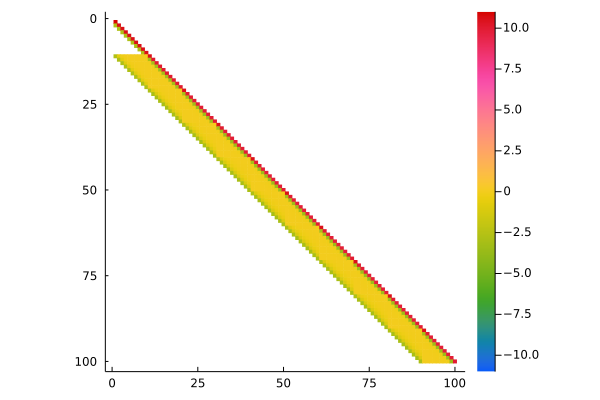

In [28]:
A = advdiff_matrix(10)
N = size(A, 1)
ch = cholesky(A, perm=1:N)
my_spy(A)
my_spy(sparse(ch.L))

# Cost of a banded solve

Consider an $N\times N$ matrix with bandwidth $b$, $1 \le b \le N$.

* Work one row at a time
* Each row/column of panel has $b$ nonzeros
* Schur update affects $b\times b$ sub-matrix
* Total compute cost $N b^2$
* Storage cost $N b$

## Question
* What bandwidth $b$ is needed for an $N = n\times n \times n$ cube in 3 dimensions?
* What is the memory cost?
* What is the compute cost?

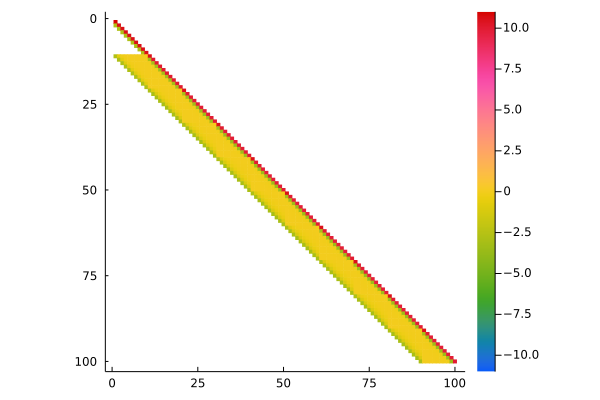

In [4]:
my_spy(sparse(ch.L))

# Different orderings

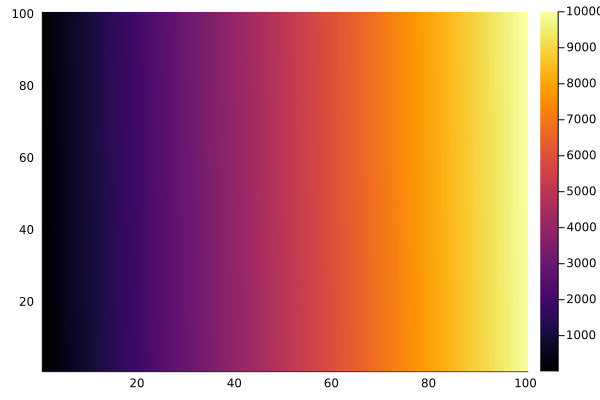

In [58]:
n = 100
A = advdiff_matrix(n)
heatmap(reshape(1:n^2, n, n))

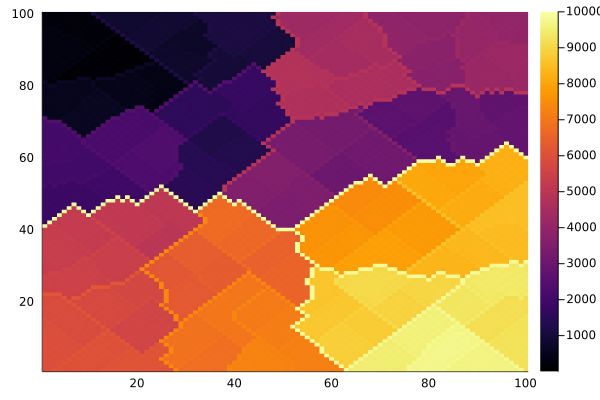

In [59]:
import Metis
perm, iperm = Metis.permutation(A)
heatmap(reshape(iperm, n, n))

In [62]:
cholesky(A, perm=1:n^2)
#my_spy(A[perm, perm])

SuiteSparse.CHOLMOD.Factor{Float64}
type:    LLt
method:  supernodal
maxnnz:  0
nnz:     330951
success: true


In [61]:
ch = cholesky(A, perm=Vector{Int64}(perm))
#my_spy(sparse(ch.L))

SuiteSparse.CHOLMOD.Factor{Float64}
type:    LLt
method:  supernodal
maxnnz:  0
nnz:     224791
success: true


# Cholesky factors in nested dissection

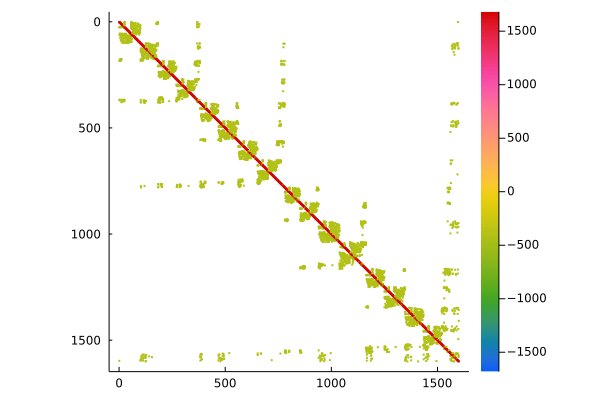

In [63]:
n = 40
A = advdiff_matrix(n)
perm, iperm = Metis.permutation(A)
my_spy(A[perm, perm])

In [64]:
ch = cholesky(A, perm=Vector{Int64}(perm))
my_spy(sparse(ch.L))

* The dense blocks in factor $L$ are "supernodes"
* They correspond to "vertex separators" in the ordering

# Cost in nested dissection

* Cost is dominated by dense factorization of the largest supernode
* Its size comes from the vertex separator size

## 2D square

* $N = n^2$ dofs
* Vertex separator of size $n$
* Compute cost $v^3 = N^{3/2}$
* Storage cost $N \log N$

## 3D Cube

* $N = n^3$ dofs
* Vertex separator of size $v = n^2$
* Compute cost $v^3 = n^6 = N^2$
* Storage cost $v^2 = n^4 = N^{4/3}$

## Questions

1. How much does the cost change if we switch from Dirichlet to periodic boundary conditions in 2D?
2. How much does the cost change if we move from 5-point stencil ($O(h^2)$ accuracy) to 9-point "star" stencil ($O(h^4)$ accuracy)?
3. Would you rather solve a 3D problem on a $10\times 10\times 10000$ grid or $100\times 100 \times 100$?

# Test our intuition

In [71]:
function laplacian_matrix(n)
    h = 2 / n
    rows = Vector{Int64}()
    cols = Vector{Int64}()
    vals = Vector{Float64}()
    wrap(i) = (i + n - 1) % n + 1
    idx(i, j) = (wrap(i)-1)*n + wrap(j)
    stencil_diffuse = [-1, -1, 4, -1, -1] / h^2
    for i in 1:n
        for j in 1:n
            append!(rows, repeat([idx(i,j)], 5))
            append!(cols, [idx(i-1,j), idx(i,j-1), idx(i,j), idx(i+1,j), idx(i,j+1)])
            append!(vals, stencil_diffuse)
        end
    end
    sparse(rows, cols, vals)
end

laplacian_matrix (generic function with 1 method)

In [75]:
n = 50
A_dirichlet = advdiff_matrix(n)
perm, iperm = Metis.permutation(A_dirichlet)
cholesky(A_dirichlet, perm=Vector{Int64}(perm))
#cholesky(A_dirichlet)

SuiteSparse.CHOLMOD.Factor{Float64}
type:    LLt
method:  simplicial
maxnnz:  40203
nnz:     40203
success: true


In [76]:
A_periodic = laplacian_matrix(n) + 1e-10*I
perm, iperm = Metis.permutation(A_periodic)
cholesky(A_periodic, perm=Vector{Int64}(perm))
#cholesky(A_periodic)

SuiteSparse.CHOLMOD.Factor{Float64}
type:    LLt
method:  supernodal
maxnnz:  0
nnz:     60083
success: true


# How expensive how fast?

Suppose we have a second order accurate method in 3D.

In [13]:
n = 2. .^ (2:13)
N = n.^3
error = (50 ./ n) .^ 2
seconds = 1e-10 * N.^2
hours = seconds / 3600
cloud_dollars = 3 * hours
kW_hours = 0.2 * hours
barrel_of_oil = kW_hours / 1700
kg_CO2 = kW_hours * 0.709
;

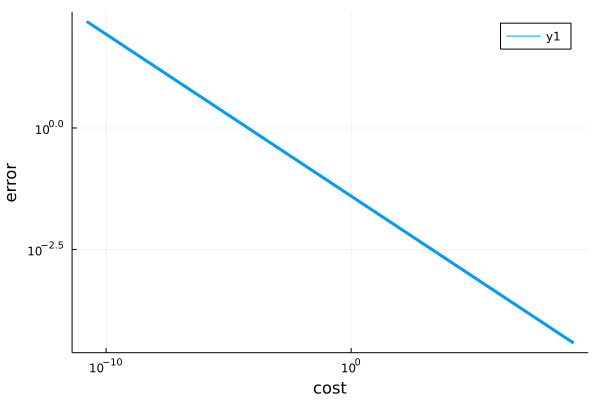

In [78]:
cost = kg_CO2
plot(cost, error, xlabel="cost", ylabel="error", xscale=:log10, yscale=:log10)

* [Barrel of oil equivalent](https://en.wikipedia.org/wiki/Barrel_of_oil_equivalent)
* [Electricity emission factor](https://www.epa.gov/energy/greenhouse-gases-equivalencies-calculator-calculations-and-references)

# Outlook on sparse direct solvers

* Sparse direct works well for 2D and almost-2D problems to medium large sizes
  * High order FD methods make sparse direct cry
  * High order finite element are okay, but [not high-continuity splines](https://doi.org/10.1016/j.cma.2011.11.002)
  * Almost-2D includes a lot of industrial solid mechanics applications
    * The body of a car, the frame of an airplane
* Sparse direct is rarely usable in "fully 3D" problems
  * "thick" structures
    * soil mechanics, hydrology, building foundations, bones, tires
  * fluid mechanics
    * aerodynamics, heating/cooling systems, atmosphere/ocean
* Setup cost (factorization) is much more expensive than solve
  * Amortize cost in time-dependent problems
    * Rosenbrock methods: factorization reused across stages
    * "lag" Jacobian in Newton (results in "modified Newton")
    * "lag" preconditioner with matrix-free iterative methods (Sundials, PETSc)
  * Factorization pays off if you have many right hand sides